In [137]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
def normalize(data):return (data-np.min(data)) / (np.max(data)-np.min(data))
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
def get_ci(samples, confidence=0.95): return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
df = utils.get_wandb_runs("wv_3d_linear_noisy")
eval_cols = ['NINO_ds_acc',  'NIFO_ds_acc', 'NI_h2h', 'NO_h2h', 'test_triplet_acc','test_clf_acc', 'test_1nn_acc', 'rNINO_ds_acc',]
config_cols = ["model","seed", "weights", "filtered", "embed_dim", "lamda", "wandb_group", "wandb_project"]
df = utils.strip_df(df, eval_cols, config_cols)

## aligns

In [160]:
df["align"] = [float(x.split("=")[-1]) for x in df["wandb_group"]]

## noisy

In [168]:
df["align"] = [float(x[6:10]) for x in df["wandb_group"]]
df["noise"] = [float(x.split("=")[-1]) for x in df["wandb_group"]]

In [171]:
df[df["align"]==0.97].to_csv("link/wv_3d_linear/wv_3d_linear_noisy_0.97.csv")
df[df["align"]==0.62].to_csv("link/wv_3d_linear/wv_3d_linear_noisy_0.62.csv")

## RESN

In [184]:
df = pd.read_csv("evals/RESN_evals.csv")
df["align"] = [float(x.split("=")[-1]) for x in df["group"]]
df = df.rename({"group":"wandb_group"},axis=1)
df["name"] = ["RESN"]*len(df)
df["model"] = ["RESN"]*len(df)

In [185]:
for col in config_cols+eval_cols:
    if col not in df.columns: df[col] = [None]*len(df)

In [186]:
df.to_csv("link/wv_3d_linear/RESN.csv")

In [122]:
df[df["align"]==1].groupby(["name"]).mean()

,seed,filtered,embed_dim,lamda,align,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
name,,,,,,,,,,,,,
MTL0.2,1.0,1.0,512.0,0.2,1.0,0.986600,0.986600,0.862786,0.911083,0.972380,0.986600,0.989112,0.986600
MTL0.5,1.0,1.0,512.0,0.5,1.0,0.989950,0.979899,0.864740,0.898241,0.975604,0.979899,0.987437,0.985762
MTL0.8,1.0,1.0,512.0,0.8,1.0,0.989950,0.988275,0.849386,0.922390,0.974276,0.988275,0.989950,0.990787
TN,1.0,1.0,512.0,0.0,1.0,0.989112,0.991625,0.883305,0.945422,0.971179,0.556114,0.991625,0.989112


In [134]:
df[df["align"]==1][["name"]+eval_cols].groupby(["name"]).agg(get_ci)

,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
name,,,,,,,,
MTL0.2,0.007207,0.025986,0.062288,0.080156,0.030150,0.025986,0.028828,0.031415
MTL0.5,0.000000,0.033027,0.067449,0.177430,0.016216,0.033027,0.024966,0.031415
MTL0.8,0.000000,0.014414,0.073302,0.111309,0.010419,0.014414,0.012483,0.007207
TN,0.031415,0.007207,0.042706,0.048093,0.025330,0.226881,0.007207,0.031415


In [133]:
df[(df["align"]==1) & (df["name"]=="MTL0.5")]

,name,model,seed,weights,filtered,embed_dim,lamda,align,wandb_project,NINO_ds_acc,NIFO_ds_acc,NI_h2h,NO_h2h,test_triplet_acc,test_clf_acc,test_1nn_acc,rNINO_ds_acc
1,MTL0.5,MTL,2,"[1, 1, 0, 0]",True,512,0.5,1.0,wv_3d_linear,0.98995,0.972362,0.850084,0.860972,0.976678,0.972362,0.987437,0.979900
9,MTL0.5,MTL,1,"[1, 1, 0, 0]",True,512,0.5,1.0,wv_3d_linear,0.98995,0.984925,0.867253,0.901591,0.971938,0.984925,0.992462,0.984925
22,MTL0.5,MTL,0,"[1, 1, 0, 0]",True,512,0.5,1.0,wv_3d_linear,0.98995,0.982412,0.876884,0.932161,0.978195,0.982412,0.982412,0.992462


In [43]:
cis = []
for align in ["0.5","0.8","0.83","0.92","0.925","1"]:
    data = df[df["group"]==f"align={align}"]["NIFO_ds_acc_k=1"]
    cis.append(np.around(get_ci(data),3))

In [112]:
df = pd.read_csv("link/wv_3d_square/wv_3d_square_num_512.csv")
MTL = df[df["wandb_name"]=="MTL0.5"]

In [113]:
# unfiltered_MTL = TN[["filtered" not in x for x in TN["wandb_group"]]]
MTL = MTL[["0.925" in x for x in MTL["wandb_group"]]]

In [118]:
cis = []
for align in [0.5,0.25,0.125,0.0625,0.03125,0.015625,0.0078125]:
    data = MTL[MTL["wandb_group"]==f"align=0.925_p={align}"]["h2h_512"]
    cis.append(np.around(get_ci(data)/2,3))

In [119]:
cis

[0.006, 0.02, 0.043, 0.016, 0.034, 0.006, 0.045]

In [2]:
train_embeds = pickle.load(open("datasets/wv_3d_linear/train_features.pkl","rb"))
test_embeds = pickle.load(open("datasets/wv_3d_linear/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d_linear/train")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d_linear/test")])

In [3]:

total_weights = np.array(list(itertools.product([0]+[10**i for i in range(7)],repeat=2)))


total_weights = np.hstack([total_weights,np.zeros_like(total_weights)])



In [4]:
w_list = total_weights
aligns = []
for weights in w_list: aligns.append(evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, weights))

(array([ 1.,  0.,  7.,  7.,  2.,  0.,  4.,  0.,  6., 37.]),
 array([0.50251256, 0.55175879, 0.60100503, 0.65025126, 0.69949749,
        0.74874372, 0.79798995, 0.84723618, 0.89648241, 0.94572864,
        0.99497487]),
 <BarContainer object of 10 artists>)

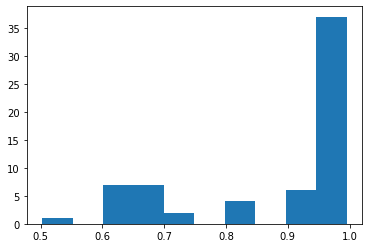

In [5]:
plt.hist(aligns)

In [36]:
w_list[33]

array([1000,    1,    0,    0])

In [27]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,0.00001,0,0])

0.8391959798994975

In [35]:
np.where(aligns==np.unique(aligns)[-6])

(array([33, 42, 51, 60]),)

In [34]:
np.unique(aligns)[-6]

0.9623115577889447

In [24]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,1,0,0])

0.985

In [9]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [0,256,1,1])


0.54

In [25]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,0,1,1])

0.84

In [22]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,256,256,256])

0.92

In [21]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [0,1,1,1])


0.5625